# AI Tools for Actuaries
## Chapter 10: PCA, SVD and BNN
### Author: Mario Wuthrich
### Version June, 2025

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

## Load and Preprocess Data

In [4]:
# Load data
import pyreadr
dat = pyreadr.read_r('../../Data/SportsCars.rda')['SportsCars']
print("Data shape:", dat.shape)
dat.head()

Data shape: (475, 13)


,brand,type,model,cubic_capacity,max_power,max_torque,seats,weight,max_engine_speed,seconds_to_100,top_speed,sports_car,tau
0,Austin,Rovermini,Ehlemayair,998,31,67.0,4,620,5000,19.5,129,0,23.338922
1,Citroen,Visa,Baseclub,652,25,49.0,5,755,5500,26.2,125,0,34.130318
2,Citroen,2CV,Specialton,602,21,39.0,4,585,5750,NaN,115,0,28.648630
3,Fiat,Panda,34,850,25,60.0,5,680,5250,32.3,125,0,32.846956
4,Opel,Ascona2,LS1.6D,1598,41,96.0,5,1015,4600,21.0,143,0,35.006434


In [5]:
# Data pre-processing
dat['x1'] = np.log(dat['weight']/dat['max_power'])
dat['x2'] = np.log(dat['max_power']/dat['cubic_capacity'])
dat['x3'] = np.log(dat['max_torque'])
dat['x4'] = np.log(dat['max_engine_speed'])
dat['x5'] = np.log(dat['cubic_capacity'])

# Select features
dat1 = dat[['x1', 'x2', 'x3', 'x4', 'x5']]


In [8]:

# Normalization of design matrix
X = dat1.values
m0 = np.mean(X, axis=0)
X01 = X - m0
sds = np.std(X01, axis=0, ddof=0)
X = X01 / sds

print("Normalized data shape:", X.shape)
print("\nCorrelation matrix:")
print(np.round(np.corrcoef(X.T), 4))

Normalized data shape: (475, 5)

Correlation matrix:
[[ 1.     -0.7484 -0.8173 -0.3074 -0.669 ]
 [-0.7484  1.      0.4552  0.61    0.1531]
 [-0.8173  0.4552  1.     -0.1076  0.9317]
 [-0.3074  0.61   -0.1076  1.     -0.2533]
 [-0.669   0.1531  0.9317 -0.2533  1.    ]]


## PCA - SVD Analysis

In [9]:
# Singular value decomposition
U, S, Vt = np.linalg.svd(X, full_matrices=False)
print("Singular values:")
print(np.round(S, 4))

# Verify eigenvalues
eigenvalues = np.linalg.eigvals(X.T @ X)
print("\nEigenvalues:")
print(np.round(eigenvalues, 2))
print("\nSquared singular values:")
print(np.round(S**2, 2))

Singular values:
[37.5328 28.0738 11.4755  6.4771  2.1238]

Eigenvalues:
[1408.71  788.14  131.69   41.95    4.51]

Squared singular values:
[1408.71  788.14  131.69   41.95    4.51]


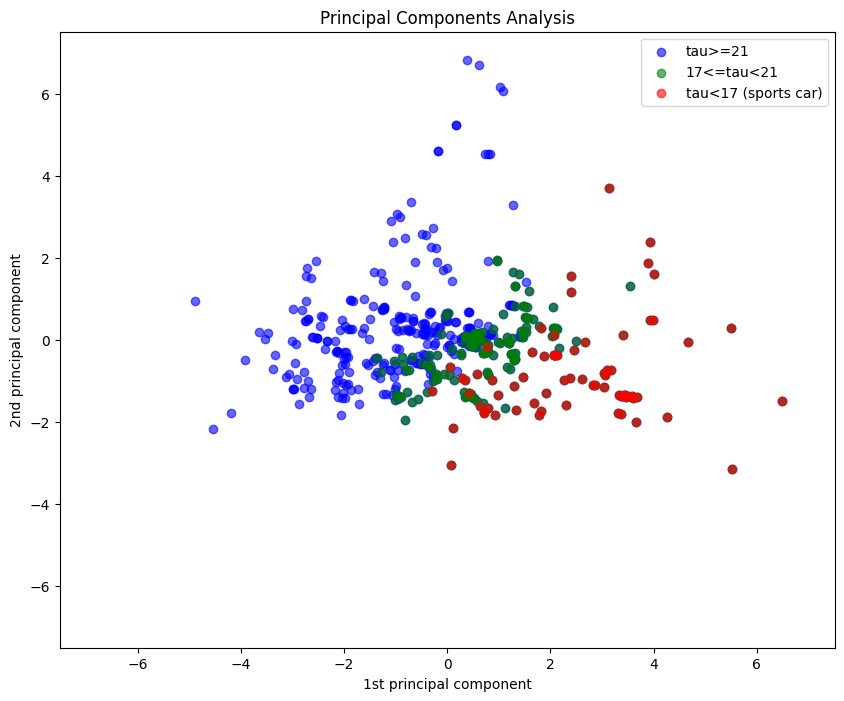

In [11]:
# Calculate principal components
dat['PCA1'] = X @ Vt[0]
dat['PCA2'] = X @ Vt[1]

# Plot PCA results
plt.figure(figsize=(10, 8))
rr = max(abs(dat['PCA1']).max(), abs(dat['PCA2']).max())*1.1

plt.scatter(dat['PCA1'], dat['PCA2'], c='blue', alpha=0.6, label='tau>=21')
plt.scatter(dat[dat['tau'] < 21]['PCA1'], dat[dat['tau'] < 21]['PCA2'], 
            c='green', alpha=0.6, label='17<=tau<21')
plt.scatter(dat[dat['tau'] < 17]['PCA1'], dat[dat['tau'] < 17]['PCA2'], 
            c='red', alpha=0.6, label='tau<17 (sports car)')

plt.xlim(-rr, rr)
plt.ylim(-rr, rr)
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.title('Principal Components Analysis')
plt.legend()
plt.show()

In [16]:
# Calculate reconstruction error
def frobenius_loss(X1, X2):
    return np.sqrt(np.sum((X1 - X2)**2) / X1.shape[0])

reconstruction_PCA = np.zeros(5)
for p in range(5):
    Xp = X @ Vt[:p+1].T @ Vt[:p+1]
    reconstruction_PCA[p] = frobenius_loss(X, Xp)

print("Reconstruction errors:")
print(np.round(reconstruction_PCA, 2))

Reconstruction errors:
[1.43 0.61 0.31 0.1  0.  ]


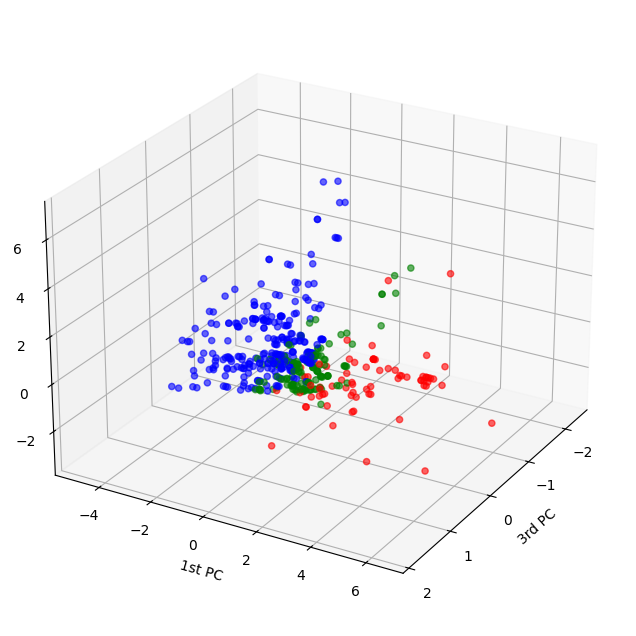

In [25]:
# 3D plot of first three principal components
dat['PCA3'] = X @ Vt[2]
colors = np.where(dat['tau'] < 17, 'red', 
                 np.where(dat['tau'] < 21, 'green', 'blue'))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(dat['PCA3'], dat['PCA1'], dat['PCA2'], 
                    c=colors, alpha=0.6)
ax.set_xlabel('3rd PC')
ax.view_init(25, 30)  # Rotate view by 30 degrees elevation and azimuth
ax.set_ylabel('1st PC')
ax.set_zlabel('2nd PC')
plt.show()

## Bottleneck Neural Network (BNN)

In [26]:
def create_bottleneck_model(input_dim, hidden_dim, bottleneck_dim, activation='tanh'):
    # Input layer
    inputs = keras.Input(shape=(input_dim,))
    
    # Encoder
    x = keras.layers.Dense(hidden_dim, activation=activation, use_bias=False)(inputs)
    encoder_output = keras.layers.Dense(bottleneck_dim, activation=activation, 
                                       use_bias=False, name='Encoder')(x)
    
    # Decoder
    x = keras.layers.Dense(hidden_dim, activation=activation, use_bias=False)(encoder_output)
    outputs = keras.layers.Dense(input_dim, activation='linear', use_bias=False)(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [28]:
# Define and train BNN
BN = 2
input_dim = X.shape[1]
hidden_dim = 9

model = create_bottleneck_model(input_dim, hidden_dim, BN)
model.compile(optimizer='nadam', loss='mse')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

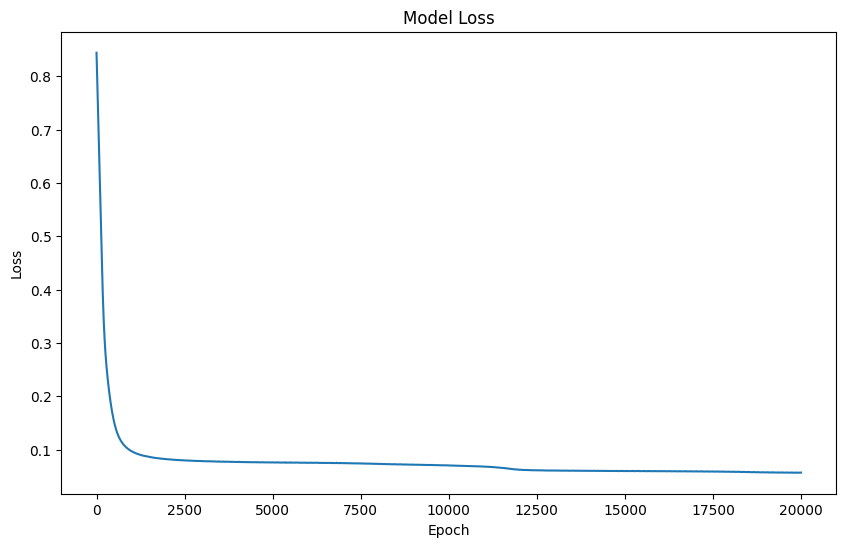

In [29]:
# THIS FITTING TAKES 8 MINUTES!
# Train the model
history = model.fit(X, X, epochs=20000, batch_size=X.shape[0], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Save model weights
# model.save_weights('./Networks/BNN_2Python.weights.h5')


In [32]:
# Load model weights
model.load_weights('./Networks/BNN_2Python.weights.h5')

In [33]:
# Get decoder output and calculate reconstruction error
decoder_output = model.predict(X)
bnn_error = frobenius_loss(X, decoder_output)
print(f"BNN reconstruction error: {bnn_error:.4f}")
print(f"PCA reconstruction error (2 components): {reconstruction_PCA[1]:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
BNN reconstruction error: 0.5348
PCA reconstruction error (2 components): 0.6124


In [39]:
# Extract
encoder_model = keras.Model(inputs=model.input, 
                           outputs=model.get_layer('Encoder').output)
bottleneck_output = encoder_model.predict(X)
print("First few rows of bottleneck output:")
print(bottleneck_output[:5])


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
First few rows of bottleneck output:
[[-0.15838356  0.22636594]
 [-0.10463792  0.46618304]
 [-0.04230772  0.47026175]
 [-0.18852103  0.350436  ]
 [-0.30795813  0.09328253]]


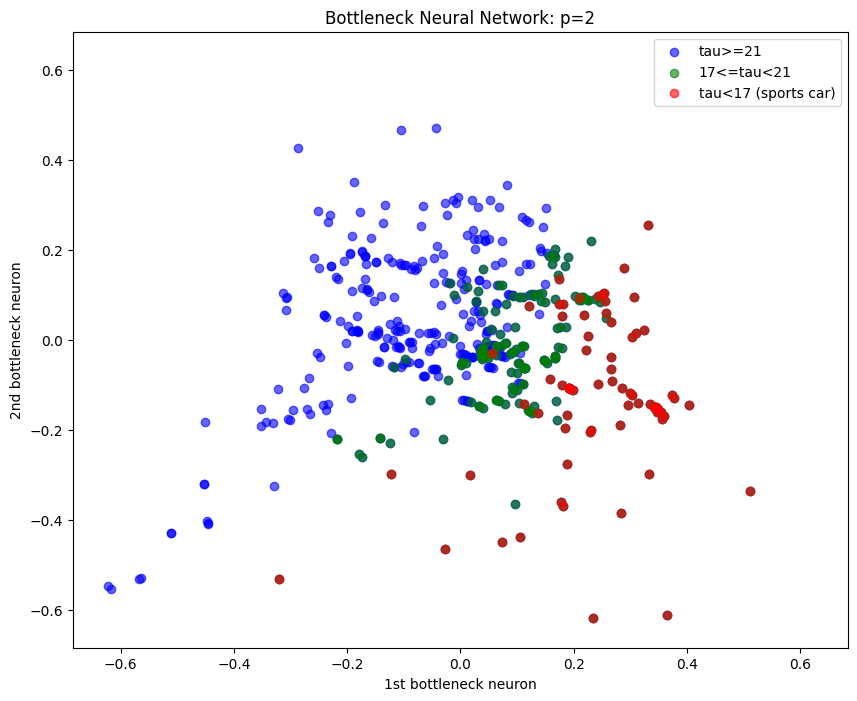

In [45]:

plt.figure(figsize=(10, 8))
rr = abs(bottleneck_output).max()*1.1

plt.scatter(bottleneck_output[:, 0], bottleneck_output[:, 1], 
            c='blue', alpha=0.6, label='tau>=21')
plt.scatter(bottleneck_output[dat['tau'] < 21, 0], 
            bottleneck_output[dat['tau'] < 21, 1], 
            c='green', alpha=0.6, label='17<=tau<21')
plt.scatter(bottleneck_output[dat['tau'] < 17, 0], 
            bottleneck_output[dat['tau'] < 17, 1], 
            c='red', alpha=0.6, label='tau<17 (sports car)')

plt.xlim(-rr, rr)
plt.ylim(-rr, rr)
plt.xlabel('1st bottleneck neuron')
plt.ylabel('2nd bottleneck neuron')
plt.title(f'Bottleneck Neural Network: p={BN}')
plt.legend()
plt.show()